%pip install torchtext
%pip install wandb

In [1]:
import pandas as pd
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import wandb
import nltk
nltk.download('punkt')
wandb.login()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


In [2]:
data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
data = data[:3000]
data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style','URL':'description'})
data = data[['image','description']]
data['image'] = [f'.{x}' for x in data['image']]
print(f'columns:{[x for x in data.columns]}')

columns:['image', 'description']


In [3]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

100%|██████████| 3000/3000 [00:36<00:00, 81.13it/s] 


In [4]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4685, 0.3801, 0.3472])
Std of the image: tensor([0.2129, 0.1872, 0.1589])


In [5]:
# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(data['image'],data['description'], test_size=0.2, random_state=42)

In [6]:
#Image Transformations
img_train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

img_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

In [7]:
from nltk.tokenize import word_tokenize
class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,images,labels,transform=None, max_caption_length=50):
        self.data = images
        self.labels = labels
        self.transform = transform
        self.max_caption_length = max_caption_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_pil = Image.open(self.data[index])
        img_pil = img_pil.convert('RGB')
        if self.transform is not None:
            img_pil = self.transform(img_pil)
        else:
            tr1 = transforms.ToTensor()
            img_pil = tr1(img_pil)

        #Tokenize caption using nltk
        caption = self.labels[index]
        tokens = word_tokenize(caption)

        if len(tokens) > self.max_caption_length:
            tokens = tokens[:self.max_caption_length]
        else:
            tokens += ['<pad>'] * (self.max_caption_length - len(tokens))


        tokenized_caption = torch.LongTensor([int(hash(token)) % (2**16-1) for token in tokens])
        return(img_pil,tokenized_caption)

train_dataset = ArtDataset(X_train.values,y_train.values,transform=img_train_transform)
val_dataset = ArtDataset(X_val.values,y_val.values,transform=img_test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 256, 256])
Labels batch shape: 16


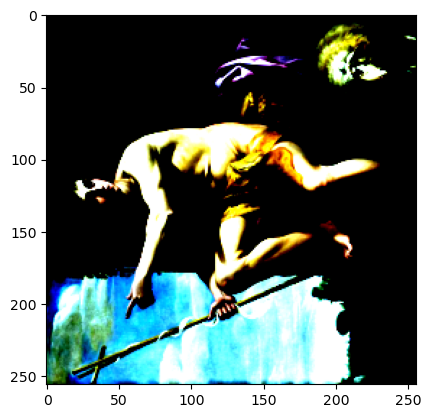

Label: tensor([[51827, 36487, 10648, 65403, 45456, 61403, 32008,  2966, 36487, 65377,
         45332, 58852, 32008, 17598, 15844, 45332, 11574, 64944, 45332, 39885,
           704, 20734,   704, 27950, 45456, 11865,  7206, 17167, 42573,  3103,
         32008, 17598, 15844, 45332, 11574, 15932, 60976, 48966, 45456, 49167,
         18194, 20434,   298, 59873, 45332, 56085, 26882,  6536, 23806,  7082],
        [ 9691, 45335, 10648, 27528, 43271, 30440, 44511, 36487, 52001, 59877,
         14292, 30731, 45332,  5630, 32008, 55341, 36487, 10648, 52362, 17167,
         29570, 64944, 45332, 21262, 32008, 10648,  1593, 44185, 11865, 61667,
         27409, 17167, 55447, 52085, 58897, 27792, 36487, 41235, 46673, 10648,
         13703, 62539, 64392, 58782, 30548, 62019, 17167, 10648, 18979, 32008],
        [46538, 54953, 48340, 11166, 17167, 61261, 43271, 47468,  5787, 64944,
         54953, 60976, 27669, 56053, 16505, 31784, 58671, 23736, 23736, 23736,
         23736, 23736, 23736, 23736, 23736,

In [8]:
batch_size = 16
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze()
label = labels
plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()
print(f"Label: {label}")

In [9]:
del data
del X_train,X_val,y_train,y_val

## Show And Tell NeuralImageCaptioning Model (Heavy)

#Encoder

class EncoderCNN(nn.Module):
    def __init__(self, embed_size = 1024):
        super(EncoderCNN,self).__init__()

        self.net = torchvision.models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)
        self.net = nn.Sequential(*list(self.net.children())[:-1])
        self.dim = 512

    def forward(self,x):
        x = self.net(x)
        x = x.permute(0,2,3,1)
        x = x.view(x.size(0),-1,x.size(-1))
        return x

#Attention

class Attention(nn.Module):

    def __init__(self,encoder_dim):
        super(Attention,self).__init__()
        self.U = nn.Linear(256,256)
        self.W = nn.Linear(encoder_dim,256)
        self.V = nn.Linear(256,1)
        self.tahn = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, img_features, hidden_state):
        U_h = self.U(hidden_state).unsqueeze(1)
        W_s = self.W(img_features)
        att = self.tahn(W_s + U_h)
        e = self.V(att).squeeze(2)
        alpha = self.softmax(e)
        context = (img_features * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha

#Decoder

class Decoder(nn.Module):

    def __init__(self,vocab_size,encoder_dim, teacher_forcing=False):
        super(Decoder, self).__init__()
        self.tf = teacher_forcing

        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim

        self.init_h = nn.Linear(encoder_dim,256)
        self.init_c = nn.Linear(encoder_dim,256)
        self.tahn = nn.Tanh()

        self.f_beta = nn.Linear(256,encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.deep_output = nn.Linear(256,vocab_size)
        self.dropout = nn.Dropout(0.5)

        self.attention = Attention(encoder_dim)
        self.embedding = nn.Embedding(vocab_size,256)
        self.lstm = nn.LSTMCell(256+encoder_dim,256)

    def get_init_lstm_state(self,img_features):
        avg_features = img_features.mean(dim=1)

        c = self.init_c(avg_features)
        c = self.tahn(c)

        h = self.init_h(avg_features)
        h = self.tahn(h)

        return h,c

    def forward(self,img_features,captions):
        batch_size = 16

        h,c = self.get_init_lstm_state(img_features)
        max_timespan = max([len(caption) for caption in captions])-1

        prev_words = torch.zeros(batch_size).long().to(device)
        if self.tf:
            embeddings = self.embedding(captions) if self.training else self.embedding(prev_words)
        else:
            embeddings = self.embedding(prev_words)

        preds = torch.zeros(batch_size, max_timespan, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, max_timespan, img_features.size(1)).to(device)
        for t in range(max_timespan):
            context,alpha = self.attention(img_features,h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            if self.tf and self.training:
                lstm_in = torch.cat((embeddings[:,t], gated_context), dim=1)    
            else:
                embeddings = embeddings.squeeze(1) if embeddings.dim()==3 else embeddings
                lstm_in = torch.cat((embeddings, gated_context), dim=1)

            h,c = self.lstm(lstm_in,(h,c))
            output = self.deep_output(self.dropout(h))

            preds[:,t] = output
            alphas[:,t] = alpha

            if not self.training or not self.tf:
                embeddings = self.embedding(output.max(1)[1].reshape(batch_size,1))
        return preds, alphas
    
    #Beam Search
    def captions(self,img_features, beam_size):
        prev_words = torch.zeros(beam_size,1).long()

        sentences = prev_words
        top_preds = torch.zeros(beam_size,1)
        alphas = torch.ones(beam_size,1,img_features.size(1))

        completed_sentences = []
        completed_sentences_scores = []
        completed_sentences_alphas = []

        step = 1
        h,c = self.get_init_lstm_state(img_features)

        while True:
            embedding = self.embedding(prev_words).squeeze(1)
            context,alpha = self.attention(img_features,h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            lstm_input = torch.cat((embedding,gated_context),dim=1)
            h,c = self.lstm(lstm_input,(h,c))
            output = self.deep_output(h)
            output = top_preds.expand_as(output) + output

            if step == 1:
                top_preds, top_words = output[0].topk(beam_size,0,True,True)
            else:
                top_preds, top_words = output.view(-1).topk(beam_size,0,True,True)
            prev_words_idx = top_words / output.size(1)
            next_words_idx = top_words % output.size(1)

            sentences = torch.cat((sentences[prev_words_idx],next_words_idx.unsqueeze(1)),dim=1)
            alphas = torch.cat((alphas[prev_words_idx],alpha[prev_words_idx].unsqueeze(1)),dim=1)

            incomplete_sentences_idx = [idx for idx, next_word in enumerate(next_words_idx) if next_word != 1]
            complete_sentences_idx = list(set(range(len(next_words_idx))) - set(incomplete_sentences_idx))

            if len(complete_sentences_idx)>0:
                completed_sentences.extend(sentences[complete_sentences_idx].tolist())
                completed_sentences_scores.extend(top_preds[complete_sentences_idx])
                completed_sentences_alphas.extend(alphas[complete_sentences_idx])
                print(complete_sentences_idx)
            beam_size -= len(complete_sentences_idx)

            if beam_size == 0:
                break

            sentences = sentences[incomplete_sentences_idx]
            alphas = alphas[incomplete_sentences_idx]
            h = h[prev_words_idx[incomplete_sentences_idx]]
            c = c[prev_words_idx[incomplete_sentences_idx]]
            img_features = img_features[prev_words_idx[incomplete_sentences_idx]]
            top_preds = top_preds[incomplete_sentences_idx].unsqueeze(1)
            prev_words = next_words_idx[incomplete_sentences_idx].unsqueeze(1)

            if step>50:
                break
            step += 1

        print(completed_sentences_scores)
        idx = completed_sentences_scores.index(max(completed_sentences_scores))
        sentence = completed_sentences[idx]
        alpha = completed_sentences_alphas[idx]
        return sentence,alpha
        

#Define the training function


def train(epoch, encoder, decoder, optimizer, cross_entropy_loss, data_loader, word_dict, alpha_c, log_interval):
    encoder.eval()
    decoder.train()

    for batch_idx, (img,caption) in enumerate(data_loader):
        imgs, captions = img.to(device), caption
        img_features = encoder(imgs)
        optimizer.zero_grad()
        preds, alphas = decoder(img_features,captions)
        targets = captions[:,1:]

        targets = nn.utils.rnn.pack_padded_sequence(targets, [len(tar)-1 for tar in targets], batch_first=True)[0]
        preds = nn.utils.rnn.pack_padded_sequence(preds, [len(pred)-1 for pred in preds], batch_first=True)[0]

        att_regularization = alpha_c * ((1 - alphas.sum(dim=1))**2).mean()
        
        loss = cross_entropy_loss(preds, targets) + att_regularization
        optimizer.step()
        loss.backward()

        total_caption_length = targets.size(0) + 1
        wandb.log({"loss":loss.item()})
        
    

## Show Attend and Tell model V2

In [10]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(Encoder,self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)

        # Remove linear and pool layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        #Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size,encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        x = self.resnet(images)
        x = self.adaptive_pool(x)
        x = x.permute(0,2,3,1)
        return x
    
    def fine_tune(self, fine_tune=True):
        #Allow computation of gradients for Conv blocks 2 through 4
        for p in self.resnet.parameters():
            p.requires_grad = False
        
        # if fine_tune:
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [11]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim) -> None:
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim,1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1+att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(1)).sum(dim=1)

        return attention_weighted_encoding, alpha
        

In [12]:
class Decoder(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(Decoder,self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)

        self.embedding = nn.Embedding(vocab_size,embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim+encoder_dim,decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim,decoder_dim)
        self.init_c = nn.Linear(encoder_dim,decoder_dim)
        self.f_beta = nn.Linear(decoder_dim,encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim,vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1,0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1,0.1)

    def load_pretrained_embeddings(self,embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
    
    def init_hidden_state(self,encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h,c
    
    def forward(self, encoder_out, encoded_captions):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        encoder_out = encoder_out.view(batch_size,-1,encoder_dim)
        num_pixels = encoder_out.size(1)

        _ , sort_idx = torch.sort(encoded_captions, dim=0, descending=True)
        encoder_out = encoder_out[sort_idx]
        encoded_captions = encoded_captions[sort_idx]

        embeddings = self.embedding(encoded_captions)

        h,c = self.init_hidden_state(encoder_out)

        decode_lengths = [len(cap) for cap in encoded_captions]

        predictions = torch.zeros(batch_size,max(decode_lengths),vocab_size).to(device)
        alphas = torch.zeros(batch_size,max(decode_lengths),num_pixels).to(device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l>t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h,c = self.decode_step(torch.cat([embeddings[:batch_size_t,t,:],attention_weighted_encoding],dim=1),
                                   (h[:batch_size_t],c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t,t,:] = preds
            alphas[:batch_size_t,t,:] = alpha

        return predictions, encoded_captions, decode_lengths, alphas

In [13]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    decoder.train()
    encoder.train()

    losses = []
    
    for i, (imgs, caps) in enumerate(train_loader):
        imgs = imgs.to(device)
        caps = caps.to(device)

        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas = decoder(imgs,caps)
        targets = caps_sorted[:,1:]
        scores = nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True)

        loss = criterion(scores[0],targets[0])
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # if grad_clip is not None:
        #     clip_gradient(decoder_optimizer, grad_clip)
        #     if encoder_optimizer is not None:
        #         clip_gradient(encoder_optimizer, grad_clip)
        
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        losses.append(loss.item(), sum(decode_lengths))
        #wandb.log({"loss": loss.item(), "epoch": epoch})

        


        


## Train and Hyperparams

In [14]:
from torchtext.vocab import GloVe
vocab = GloVe(name='6B', dim=50)

In [15]:
#Parameters and Hyperparameters

#Model Parameters
embed_dim = 50
attention_dim = 512
decoder_dim = 512
dropout = 0.5

#Training Hyperparameters
epochs = 2
encoder_lr = 1e-4
decoder_lr = 4e-4
alpha_c = 1.0
fine_tune_encoder = False
checkpoint = None


In [108]:
# run = wandb.init(
#     project='Art',
#     config={
#         "learning_rage": 0.001,
#         "epochs": 2,
#     }
# )

decoder = Decoder(attention_dim=attention_dim,embed_dim=embed_dim,decoder_dim=decoder_dim,vocab_size=len(vocab),dropout=dropout)
decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),lr=decoder_lr)

encoder = Encoder()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),lr=encoder_lr) if fine_tune_encoder else None

decoder = decoder.to(device)
encoder = encoder.to(device)

criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    train(trainloader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch)
    

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 20552089600 bytes.

In [ ]:
#Define the evaluation function
def evaluate(valloader,encoderdecoder, loss_fn):
    for i, (images,descriptions) in enumerate(valloader):
        images = images.to(device)
        descriptions = descriptions.to(device)
        outputs = encoderdecoder(images,descriptions)
        loss = loss_fn(outputs,descriptions)
        if i % 100 == 0:
            print(f'Batch: {i}, Loss: {loss.item()}')

In [ ]:
#Define the prediction function
def predict(encoderdecoder,image):
    image = image.to(device)
    feature = encoderdecoder.encoder(image).unsqueeze(1)
    sampled_ids = []
    states = None
    for i in range(20):
        hiddens,states = encoderdecoder.decoder.lstm(feature,states)
        outputs = encoderdecoder.decoder.fc(hiddens.squeeze(1))
        predicted = outputs.max(1)[1]
        sampled_ids.append(predicted)
        feature = encoderdecoder.decoder.embed(predicted)
        feature = feature.unsqueeze(1)
    sampled_ids = torch.stack(sampled_ids,1)
    sampled_ids = sampled_ids[0].cpu().numpy()
    return sampled_ids

In [ ]:
#Define the function to convert the predicted ids to words
def convert_to_words(sampled_ids):
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    return sentence

In [ ]:
#Define the function to display the image and the predicted caption
def display_image_caption(image,sentence):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(sentence)
    plt.show()

In [ ]:
#Define the function to display the image and the actual caption
def display_image_caption_actual(image,caption):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(caption)
    plt.show()